# Lesson 4 P1 - FastAI

## Learning the basics of classification
Now that we are comfortable creating models useing FastAI's toolkit, lets go back to the basics. Below is a simple MNIST dataset containing 3's and 7's. Lets try to classify this without using FastAI's toolkit.

### Getting and viewing data

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)  #path for data

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()


(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted() #getting 3's data from path
sevens = (path/'train'/'7').ls().sorted() #getting 7's data from path
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path) #shows image
im3

In [9]:
array(im3)[4:10,4:10] #numpy to convert image into quantitative rep

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
tensor(im3)[4:10,4:10] #same thing as numpy array but work better on GPU's (preferred)

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
im3.shape

(28, 28)

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys') #Using panda's framework

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity
Why don't we begin by creating an ideal image of a three based on the training set. Then having that ideal image compared with the other images of 3's and 7's to classify them?

In [13]:
#create list of all images in the form of tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

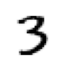

In [33]:
show_image(three_tensors[1]);

In [ ]:
type(three_tensors)

list

> Right now our tensors are lists. We must fix this by stacking them.

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [16]:
len(stacked_threes.shape) #Returns rank. Rank means it has n dementions

3

In [17]:
stacked_threes.ndim

3

In [15]:
mean3 = stacked_threes.mean() #notice taking mean gives a number
mean3

tensor(0.1415)

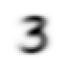

In [16]:
mean3 = stacked_threes.mean(0) #the 0 represents the axis we are doing the mean across (In this case across the first axis 6131)
show_image(mean3);

> Here's our ideal 3

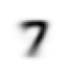

In [17]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

> And our ideal 7, which we will also be using as a comparison

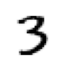

In [18]:
a_3 = stacked_threes[1]
show_image(a_3);

### Difference formula
To determine the difference between our ideal image and the training images we need to make use of some formula. Particularly, using either the **mean absolute difference(L1 norm)** or the **root mean squared error(L2 norm)**.

In [ ]:
#Find difference between images using one of the following:
dist_3_abs = (a_3 - mean3).abs().mean() #L1 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() #RMSE or L2 norm
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [ ]:
#Another approach
F.l1_loss(a_3.float(),mean7),   F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## Sidebar: NumPy Arrays and PyTorch Tensors 
#### ***Just some comparison between tensors and numpy arrays***

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
tns[1]

tensor([4, 5, 6])

In [ ]:
tns[:,1]

tensor([2, 5])

In [ ]:
tns[1,1:3]

tensor([5, 6])

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [ ]:
tns.type()

'torch.LongTensor'

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## End Sidebar

### Training set
As before, lets create our training set, or validation set in this case. Similer to before, we will be stacking all the images.

In [19]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255


valid_3_tens.shape,   valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### Loss function
This is our chosen distance formula. We will be using this to classify 3's and 7's.

In [20]:
def mnist_distance(a,b): 
  return (a-b).abs().mean((-1,-2)) #mean across 2nd and last axis (28,28)
mnist_distance(a_3, mean3)

tensor(0.1114)

## Computing Metrics Using Broadcasting
Broadcasting is a technique of vectorizing array operations so that looping occurs in C instead of Python. This is far more efficient and faster than looping. See below broadcasting in action, along with an example.

In [21]:
valid_3_dist = mnist_distance(valid_3_tens, mean3) #broadcast method across entire validation set
valid_3_dist, valid_3_dist.shape

(tensor([0.1787, 0.1422, 0.1412,  ..., 0.1358, 0.1301, 0.1110]),
 torch.Size([1010]))

In [ ]:
tensor([1,2,3]) + tensor([1]) #broadcasting example

tensor([2, 3, 4])

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [19]:
#Simple function that calls the loss func and returns true or false
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [ ]:
a_7 = stacked_sevens[1]
a_7

<AxesSubplot:>

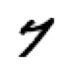

In [26]:
show_image(a_7)

In [ ]:
is_3(a_7), is_3(a_7).float() #tensor val is 0

(tensor(False), tensor(0.))

> Nice it's working!

In [ ]:
is_3(valid_3_tens) #Broadcasting

tensor([True, True, True,  ..., True, True, True])

## Testing
Now lets test it and view our accuracy!

In [20]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

> Wow 95% accuracy! You just created your very first model from scratch!

## Lets test our model using our own image

In [65]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

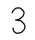

In [66]:
img = PILImage.create(uploader.data[0])
img.to_thumb(40)

> I drew this in paint

In [67]:
img = img.resize((28,28)) #Resizing img

In [68]:
t_3 = tensor(img) #converting to tensor

In [69]:
#t_3.view(-1,28*28)

In [70]:
t_3.shape

torch.Size([28, 28, 3])

In [71]:
t_3 = t_3[:,:,0] #dropping channels

<AxesSubplot:>

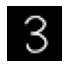

In [72]:
show_image(t_3) #Awesome now it looks like an image from our dataset

In [73]:
t_3.shape

torch.Size([28, 28])

In [74]:
is_3(t_3) #Nice, it got it right!

tensor(True)

## Conclusion
I recommend you play around with this model we created, and try to spot some limitations to it. Although this is a ML model, it certainly is far from the ideal ML models.

## Stochastic Gradient Descent (SGD)
What makes machine learning models truly learnable is SGD. Below you will see the influence of SGD on training a model.

### An End-to-End SGD Example

In [48]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

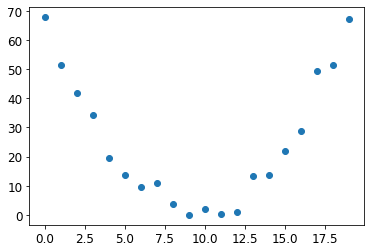

In [49]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

> Lets assume we have this data given

In [50]:
#our assumed function for the above graph
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [51]:
#Our loss function from before
def mse(preds, targets): 
    return ((preds-targets)**2).mean().sqrt() #mean squared error

### Step 1: Initialize the parameters
All ML models have parameters. Parameters are random values that represent the influence of each value on the output. We often refer to these as weights. 

In [52]:
params = torch.randn(3).requires_grad_() #Getting random weights and requiring gradient
params

tensor([0.2815, 0.0562, 0.5227], requires_grad=True)

> We are requiring gradients because this is what we will be using to improve our weights

In [53]:
#hide
orig_params = params.clone()

### Step 2: Calculate the predictions
Lets get a prediction using the random weights we initialzed above.

In [54]:
preds = f(time, params)

In [55]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

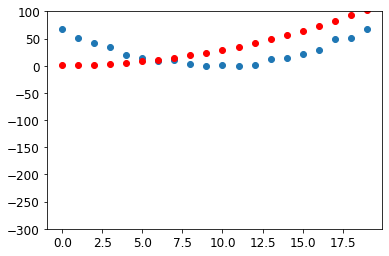

In [56]:
show_preds(preds) #Red is our predictions, Blue is the labels

> Not bad for an initial prediction

### Step 3: Calculate the loss
Lets now calculate the loss. Loss is a metric that is used by the model to determine it's performance.

In [58]:
loss = mse(preds, speed) #Current loss
loss

tensor(35.6327, grad_fn=<SqrtBackward>)

### Step 4: Calculate the gradients
To improve the loss, the gradients of the weights need to be calculated. Why the gradient? Because the gradient gives us the slope, which we need to determine how to step the weights.

In [59]:
loss.backward()
params.grad

tensor([121.4830,   7.8875,   0.3013])

In [60]:
params.grad * 1e-5      #1e-5 is the learning rate

tensor([1.2148e-03, 7.8875e-05, 3.0131e-06])

### Step 5: Step the weights. 
Now that we have everything, lets update our weights

In [62]:
lr = 1e-4
params.data -= lr * params.grad.data
params.grad = None

In [63]:
preds = f(time,params)
mse(preds, speed) #loss improved

tensor(34.1798, grad_fn=<SqrtBackward>)

> Notice that our loss has improved with these new weights

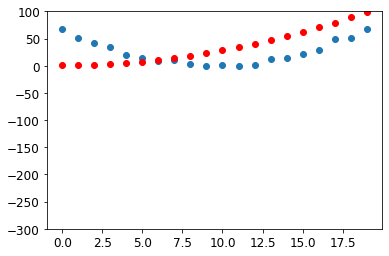

In [64]:
show_preds(preds)

## Putting all of the above into a simple function
Lets grab all the steps we did above and put it into one function for simplicity.

In [65]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

### Step 6: Repeat the process  (Training)
Now we just need to trian our model.

In [66]:
for i in range(10): apply_step(params) #running it 10 times (Notice loss improving)

34.17982482910156
32.844730377197266
31.63145637512207
30.54193687438965
29.575712203979492
28.729764938354492
27.998600006103516
27.374542236328125
26.84825325012207
26.409330368041992


In [67]:
#hide
params = orig_params.detach().requires_grad_()

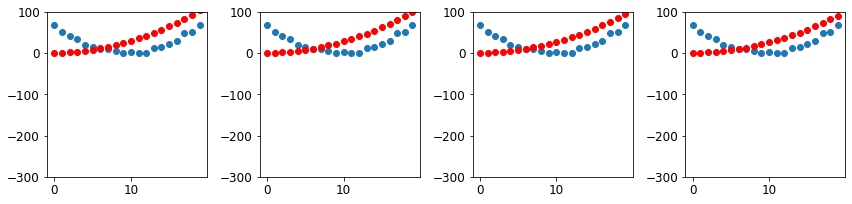

In [68]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

## Conclusion
Compare this approach to the pixel similerity example. You will notice that here it truly seems like the model is learning: This is the approach we will be using from now on as it better fits the ideal ML model. 

I have chosen to split this lesson into 2 parts. On the next lesson we will apply what we have learned to the MNIST dataset once again. This time using the more approriate ML approach.